## APPROCCIO ML

In [ ]:
import pandas as pd

import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, make_scorer


from sklearn.base import BaseEstimator, TransformerMixin
from category_encoders.target_encoder import TargetEncoder

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor

from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.optimizers import Adam

In [ ]:
#Caricamento dataset da file
train_set = pd.read_csv("C:/Users/marco/OneDrive/Desktop/Hackathon/House/train.csv", index_col = 'Id')
test_X = pd.read_csv("C:/Users/marco/OneDrive/Desktop/Hackathon/House/test.csv", index_col = 'Id')
# test_y = pd.read_csv("/content/drive/MyDrive/hackathon_colab/Houses Prices/sample_submission.csv", index_col = 'Id')

In [ ]:
# Calcolo statistiche generali sul dataset
train_set.info()

In [ ]:
pd.set_option('display.max_columns', None)  # Mostra tutte le colonne
pd.set_option('display.width', 1000)        # Aumenta la larghezza massima della riga
train_set.describe(include='all')

In [ ]:
train_set =  train_set.drop(columns=['Alley','MasVnrType','FireplaceQu','PoolQC', 'Fence', 'MiscFeature'])
test_X = test_X.drop(columns=['Alley','MasVnrType','FireplaceQu','PoolQC', 'Fence', 'MiscFeature'])

In [ ]:
# Correlazione variabili numeriche
numeric_features = train_set.select_dtypes(include=["int64", "float64"])
correlation_matrix = numeric_features.corr()
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matrice di Correlazione - Titanic")
plt.show()



In [ ]:
# Train e Validation Split
y_drop = train_set.SalePrice

# Applica la trasformazione logaritmica alla variabile target
y_drop = np.log1p(y_drop)
X_drop = train_set.drop(['SalePrice'], axis=1)
X_train, X_val, y_train, y_val = train_test_split(X_drop, y_drop, test_size=0.2, random_state=26)

Pipeline

In [ ]:
# Selezione colonne imputazione

# Trova le colonne con valori nulli
null_values = train_set.isnull().sum()
cols_with_null = null_values[null_values > 0].index.tolist()

# Separa le colonne nulle in numeriche e categoriche
num_cols  = X_train[cols_with_null].select_dtypes(include=np.number).columns.tolist()
cat_cols  = X_train[cols_with_null].select_dtypes(include='object').columns.tolist()

print("Colonne numeriche con valori nulli:", num_cols)
print("Colonne categoriche con valori nulli:", cat_cols)


Colonne numeriche con valori nulli: ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']
Colonne categoriche con valori nulli: ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']


In [ ]:
# Trova le colonne del test set con valori nulli
null_values_test = test_X.isnull().sum()
cols_with_null_test = null_values_test[null_values_test > 0].index.tolist()

# Separa le colonne nulle del test set in numeriche e categoriche
num_cols_test = test_X[cols_with_null_test].select_dtypes(include=np.number).columns.tolist()
cat_cols_test = test_X[cols_with_null_test].select_dtypes(include='object').columns.tolist()

# Trova le colonne numeriche nel test set con null che non sono in num_cols
missing_num_cols = [col for col in num_cols_test if col not in num_cols]

# Trova le colonne categoriche nel test set con null che non sono in cat_cols
missing_cat_cols = [col for col in cat_cols_test if col not in cat_cols]

print("Colonne numeriche del test set con null mancanti in num_cols:", missing_num_cols)
print("Colonne categoriche del test set con null mancanti in cat_cols:", missing_cat_cols)

# Aggiungi le colonne mancanti alle liste originali (se necessario)
num_cols.extend(missing_num_cols)
cat_cols.extend(missing_cat_cols)

print("\nListe aggiornate:")
print("Colonne numeriche con valori nulli (aggiornate):", num_cols)
print("Colonne categoriche con valori nulli (aggiornate):", cat_cols)

Colonne numeriche del test set con null mancanti in num_cols: ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea']
Colonne categoriche del test set con null mancanti in cat_cols: ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'Functional', 'SaleType']

Liste aggiornate:
Colonne numeriche con valori nulli (aggiornate): ['LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea']
Colonne categoriche con valori nulli (aggiornate): ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'Functional', 'SaleType']


In [ ]:
# Selezione colonne ordinal encoding

ordinal_cols = [
    'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual',
    'Functional', 'GarageFinish', 'GarageQual', 'GarageCond'
]

ordinal_categories = [
    ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],                 # Utilities
    ['Sev', 'Mod', 'Gtl'],                                 # LandSlope
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],                        # ExterQual
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],                        # ExterCond
    ['Na', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],                  # BsmtQual
    ['Na','Po', 'Fa', 'TA', 'Gd', 'Ex'],                  # BsmtCond
    ['NA', 'No', 'Mn', 'Av', 'Gd'],                        # BsmtExposure
    ['NA', 'Unf', 'LwQ','Rec', 'BLQ', 'ALQ', 'GLQ'],             # BsmtFinType1
    ['NA', 'Unf', 'LwQ','Rec', 'BLQ', 'ALQ', 'GLQ'],             # BsmtFinType2
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],                        # HeatingQC
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],                        # KitchenQual
    ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'], # Functional
    ['NA', 'Unf', 'RFn', 'Fin'],                           # GarageFinish
    ['Na','Po', 'Fa', 'TA', 'Gd', 'Ex'],                  # GarageQual
    ['Na','Po', 'Fa', 'TA', 'Gd', 'Ex']                   # GarageCond
]

target_enc_col = ['Neighborhood']

In [ ]:
# Seleziona le colonne di tipo 'object'
all_object_cols = X_train.select_dtypes(include='object').columns.tolist()

# Converti le liste in set per una ricerca efficiente
ordinal_cols_set = set(ordinal_cols)
target_enc_col_set = set(target_enc_col)

# Inizializza la lista per le colonne per One-Hot Encoding
onehot_cols = []

# Itera sulle colonne di tipo 'object' e aggiungi quelle che non sono in ordinal_cols o target_enc_col
for col in all_object_cols:
    if col not in ordinal_cols_set and col not in target_enc_col_set:
        onehot_cols.append(col)

print("Colonne per One-Hot Encoding:", onehot_cols)

Colonne per One-Hot Encoding: ['MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'GarageType', 'PavedDrive', 'SaleType', 'SaleCondition']


In [ ]:
# Pipeline numeriche
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Pipeline categoriche con imputazione
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline solo one-hot (senza imputazione)
onehot_only_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline ordinali
ordinal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=ordinal_categories))
])

# Pipeline target encoding
target_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target_enc', TargetEncoder())
])

In [ ]:

# Preprocessor per le colonne
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, num_cols),
        ('cat', categorical_pipeline, cat_cols),
        ('onehot_only', onehot_only_pipeline, onehot_cols),
        ('ord', ordinal_pipeline, ordinal_cols),
        ('target', target_pipeline, target_enc_col),
    ],
    remainder='passthrough'  # Mantieni le altre colonne intatte
)


colsample_bytree = 0.7203513239267079
learning_rate = 0.06696809887549353
max_depth = 3
n_estimators = 286
subsample = 0.8438257335919588
random_state = 26

# model = XGBRegressor(colsample_bytree=colsample_bytree, learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, subsample=subsample, random_state=random_state)

model = RandomForestRegressor(random_state=26)

# model = DecisionTreeRegressor(max_depth=10)

# Crea la pipeline con il preprocessor e il modello Random Forest
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

In [ ]:
# Addestra la pipeline sui dati di training
from sklearn.metrics import mean_squared_error
pipeline.fit(X_train, y_train)

# Fai previsioni sui dati di validation
y_pred_val = pipeline.predict(X_val)

# Calcola il Mean Squared Error (MSE)
mse_val = mean_squared_error(y_val, y_pred_val)

# Calcola il Root Mean Squared Error (RMSE)
rmse_val = np.sqrt(mse_val)

# Stampa il RMSE sui dati di validation
print(f"Root Mean Squared Error: {rmse_val}")

Root Mean Squared Error: 0.14363087281336664


Testing

In [ ]:
y_pred_test = pipeline.predict(test_X)

# Calcola l'accuracy score
mae_test = mean_absolute_error(test_y,y_pred_test)
# Stampa l'accuracy score
print(f"Mean Absolute Error: {mae_test}")

Mean Absolute Error: 55371.7109375


In [ ]:
# Creazione submission

predictions_df = pd.DataFrame({'Id': test_X.index, 'SalePrice': y_pred_test})

predictions_df.to_csv('/content/drive/MyDrive/hackathon_colab/Houses Prices/submission.csv', index=False)

Grid Search/RandomizedSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

# Definisci la griglia dei parametri per XGBRegressor
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__max_depth': [3, 5, 7],
    'classifier__subsample': [0.7, 1.0],
    'classifier__colsample_bytree': [0.7, 1.0],
}

# Grid search con cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Migliori parametri
print("Migliori parametri:", grid_search.best_params_)
print("RMSE migliore (negativo):", grid_search.best_score_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Migliori parametri: {'classifier__colsample_bytree': 0.7, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 300, 'classifier__subsample': 0.7}
RMSE migliore (negativo): -25381.3859375


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

param_dist = {
    'classifier__n_estimators': randint(100, 400),
    'classifier__learning_rate': uniform(0.01, 0.2),
    'classifier__max_depth': randint(3, 10),
    'classifier__subsample': uniform(0.6, 0.4),
    'classifier__colsample_bytree': uniform(0.6, 0.4),
}

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=40,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Migliori parametri:", random_search.best_params_)
print("RMSE migliore (negativo):", random_search.best_score_)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Migliori parametri: {'classifier__colsample_bytree': np.float64(0.7203513239267079), 'classifier__learning_rate': np.float64(0.06696809887549353), 'classifier__max_depth': 3, 'classifier__n_estimators': 286, 'classifier__subsample': np.float64(0.8438257335919588)}


Cross-Validation

In [ ]:

from sklearn.model_selection import cross_val_score

# Usa 'neg_root_mean_squared_error' per la cross-validation
scores_rmse = cross_val_score(pipeline, X_drop, y_drop,
                              cv=5,
                              scoring='neg_root_mean_squared_error')

# Converti i punteggi negativi in RMSE positivi
rmse_scores = -scores_rmse

print("RMSE scores for each fold:", rmse_scores)
print("Average RMSE:", rmse_scores.mean())


RMSE scores for each fold: [0.1108265  0.14090233 0.12969418 0.11340121 0.12928505]
Average RMSE: 0.12482185512636139


# Rete Neurale

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

def rmse(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')  # cast esplicito a float32
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

early_stopping = callbacks.EarlyStopping(
    min_delta=0.01, # minimium amount of change to count as an improvement
    patience=15, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[319]),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1)
])



model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=rmse,           # loss personalizzata RMSE
    metrics=[rmse]       # metrica RMSE
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Pipeline con scaler per la rete neurale

# Identify all numerical columns to apply scaling
all_numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()


# Modifica all_numeric_cols per escludere le colonne già in num_cols
all_numeric_cols_for_scaling = [col for col in all_numeric_cols if col not in num_cols]

# Pipeline numerica specifica per la rete neurale (imputazione + scaling)
numeric_pipeline_nn = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Create the second preprocessor with the updated structure
preprocessor_nn = ColumnTransformer(
    transformers=[
        ('num_impute_scale', numeric_pipeline_nn, num_cols),
        ('num_scale_only', StandardScaler(), all_numeric_cols_for_scaling),
        ('cat', categorical_pipeline, cat_cols),
        ('onehot_only', onehot_only_pipeline, onehot_cols),
        ('ord', ordinal_pipeline, ordinal_cols),
        ('target', onehot_only_pipeline, target_enc_col),
    ],
    remainder='passthrough'
)


In [ ]:
nn_X_train = X_train
nn_valid = X_val

In [ ]:
nn_X_train = preprocessor_nn.fit_transform(nn_X_train, y_train)
nn_valid = preprocessor_nn.transform(nn_valid)

Best Validation Loss (RMSE): 0.2199
Best Validation RMSE: 0.2174


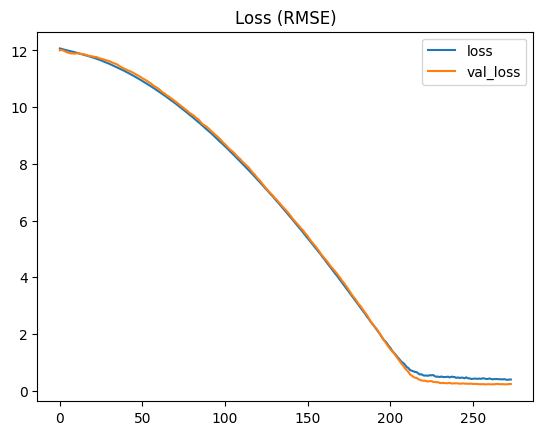

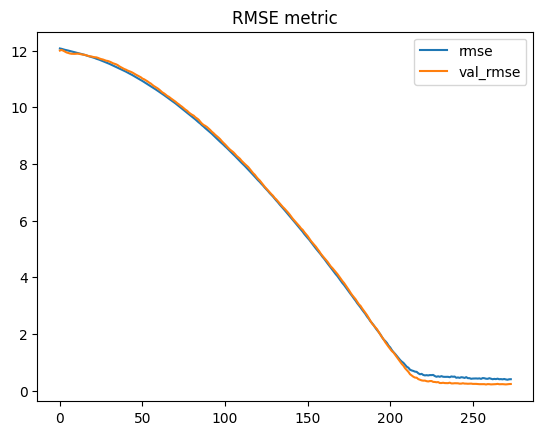

In [ ]:
# Seed per riproducibilità
keras.utils.set_random_seed(26)

history = model.fit(
    nn_X_train, y_train,
    validation_data=(nn_valid, y_val),
    batch_size=64,
    epochs=500,
    callbacks=[early_stopping],
    verbose=0,  # turn off training log
)

history_df = pd.DataFrame(history.history)

# Grafica la loss (RMSE)
history_df.loc[:, ['loss', 'val_loss']].plot(title='Loss (RMSE)')

# Grafica anche la metrica RMSE
history_df.loc[:, ['rmse', 'val_rmse']].plot(title='RMSE metric')

print(("Best Validation Loss (RMSE): {:0.4f}" +\
       "\nBest Validation RMSE: {:0.4f}").format(
           history_df['val_loss'].min(),
           history_df['val_rmse'].min()))

In [ ]:
# Prepara i dati di test
nn_test = preprocessor_nn.transform(test_X)

# Fai previsioni sul test set
y_pred_nn = model.predict(nn_test)


# Calcola il Mean Absolute Error (MAE)
# Assicurati che test_y contenga i valori target reali per il test set

mae_test_nn = mean_absolute_error(test_y, y_pred_nn)

# Stampa il MAE
print(f"Mean Absolute Error sul test set (Rete Neurale): {mae_test_nn}")

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Mean Absolute Error sul test set (Rete Neurale): 49225.9296875


In [ ]:
# Creazione del DataFrame di submission per la rete neurale
predictions_nn_df = pd.DataFrame({'Id': test_X.index, 'SalePrice': y_pred_nn.flatten()})

# Salva il file di submission
predictions_nn_df.to_csv('/content/drive/MyDrive/hackathon_colab/Houses Prices/submission_nn.csv', index=False)

print("File di submission per la rete neurale creato: submission_nn.csv")

File di submission per la rete neurale creato: submission_nn.csv


# PROVIAMO AD INSERIRE ROBA DA COLAB SU GIT

In [1]:
print("messo io")

messo io
